# Library imports

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline

# Import the train data

In [4]:
train_df = pd.read_csv('train.csv', index_col=0)

c:\users\nelgoh\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Viewing the first 5 rows of data

In [6]:
train_df.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,,,,,,,,,,,,,,,,,,,,,
0,24,0,0,5,247.30,2,0,4,17,1050,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,440875,1,1,0,37.65,1,1,0,45,1072,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,878242,2,0,1,93.73,1,0,2,54,1404,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,1319841,3,0,0,95.88,0,0,0,86,1069,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,1757883,4,0,1,0.00,0,0,1,58,1034,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


# Removing duplicate rows

In [45]:
train_df.drop_duplicates(inplace=True)

# Exploring the data

## 1. Checking for nulls in our values, print out column name if null values found

In [46]:
for each_column in train_df.columns:
    # If there are null values in the column
    if (train_df[each_column].isnull().values.any()):
        # Print it out
        print("Column \'" + each_column + "\'" + " has null values: " + str(train_df[each_column].isnull().values.any()))

## 2. Checking the number of rows in the train data

In [47]:
train_df.shape[0]

4357336

## 3. Visualizing the data

In [48]:
mpl.rcParams['agg.path.chunksize'] = 10000

### Kills VS Damage dealt

Text(0,0.5,'Amount of Damage Dealt')

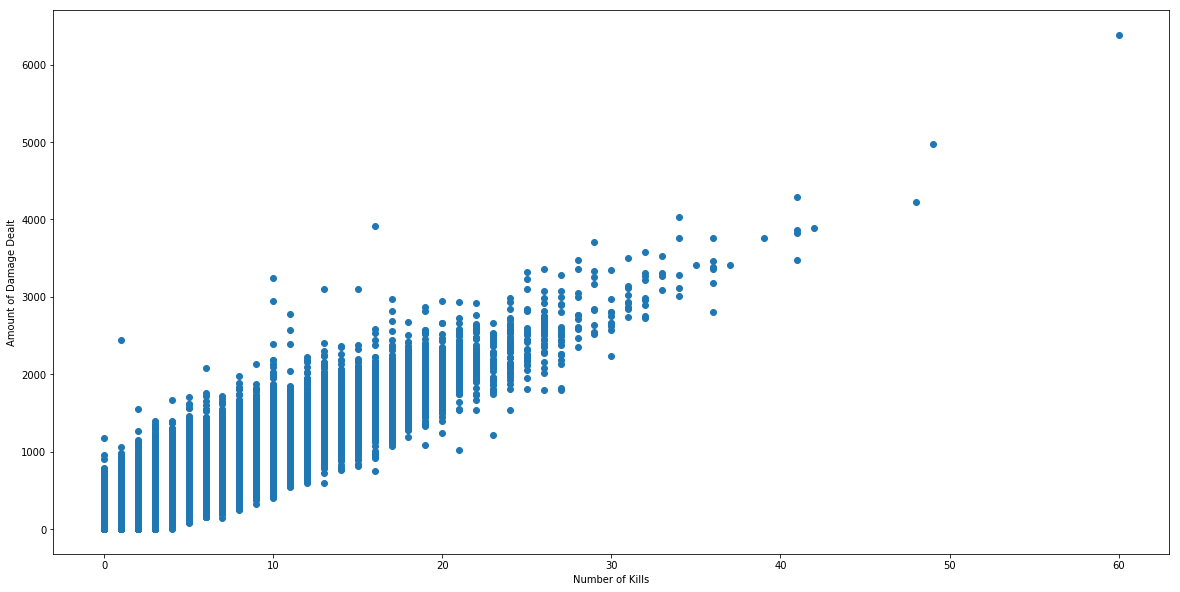

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(train_df['kills'], train_df['damageDealt'], 'o')
plt.xlabel("Number of Kills")
plt.ylabel("Amount of Damage Dealt")

### Median damage dealt per kill

c:\users\nelgoh\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\nelgoh\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0,0.5,'Median Damage Dealt')

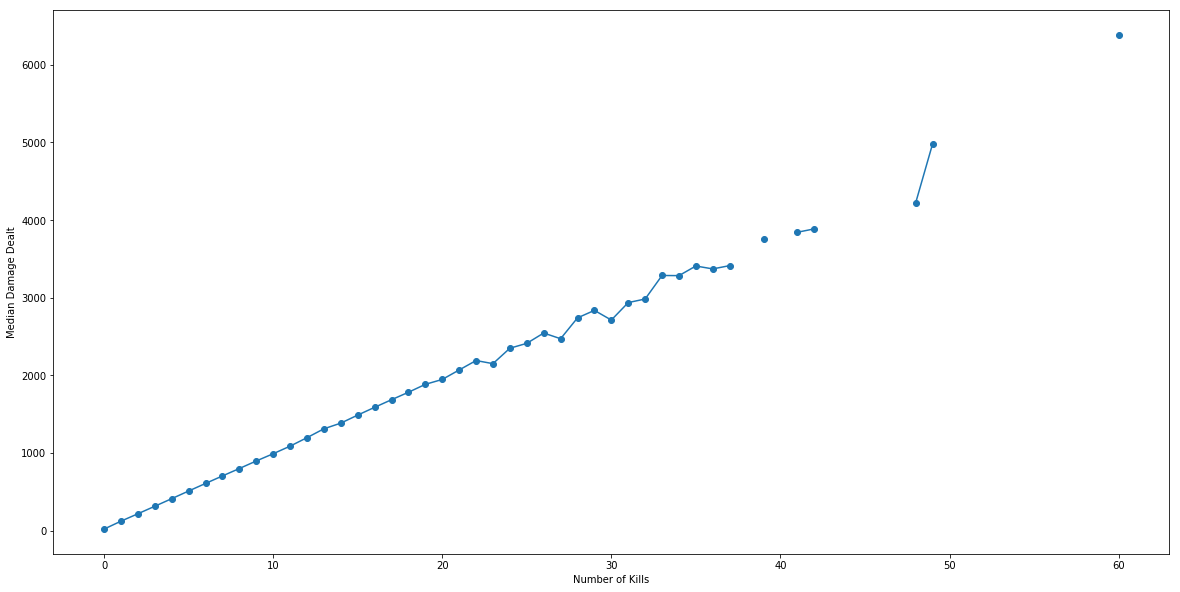

In [63]:
min_num_kills = min(train_df['kills'])
max_num_kills = max(train_df['kills'])

median_dmg_per_kill_df = pd.DataFrame(columns=['kills', 'median_dmg'])

for i in range(min_num_kills, max_num_kills + 1):
    median_dmg_per_kill_df = median_dmg_per_kill_df.append({
        'kills': i,
        'median_dmg': np.median(train_df.loc[train_df['kills'] == i]['damageDealt'])
    }, ignore_index=True)

plt.figure(figsize=(20, 10))
plt.plot(median_dmg_per_kill_df['kills'], median_dmg_per_kill_df['median_dmg'], '-o')
plt.xlabel("Number of Kills")
plt.ylabel("Median Damage Dealt")

### Number of players VS kills

c:\users\nelgoh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


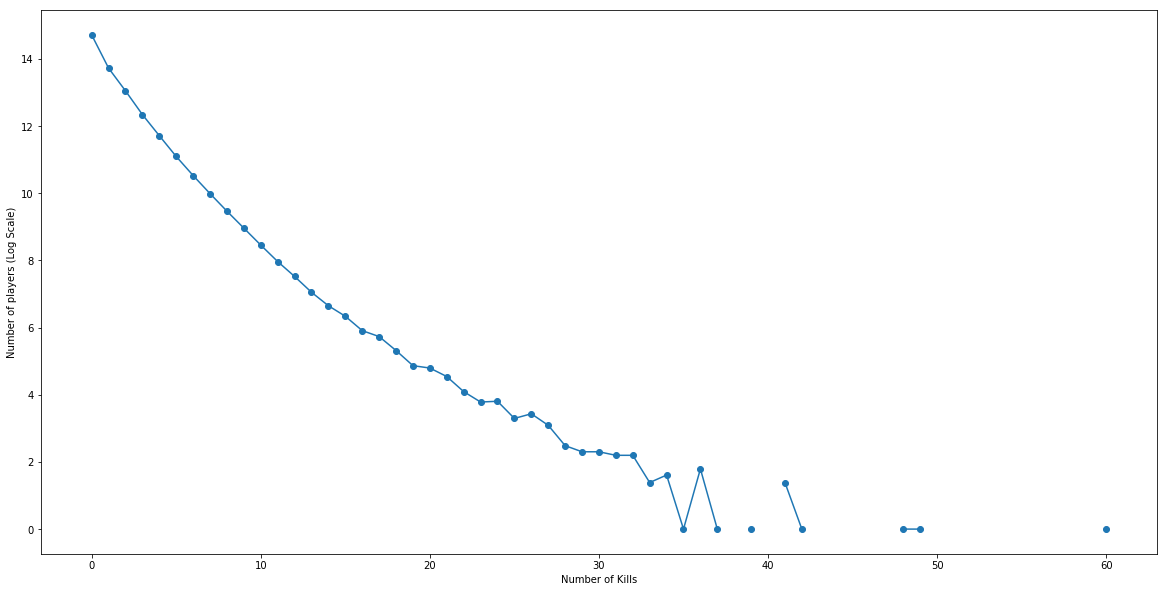

In [66]:
min_num_kills = min(train_df['kills'])
max_num_kills = max(train_df['kills'])

players_vs_kills = pd.DataFrame(columns=['kills', 'num_of_players'])

for i in range(min_num_kills, max_num_kills + 1):
    players_vs_kills = players_vs_kills.append({
        'kills': i,
        'num_of_players_log': np.log(train_df.loc[train_df['kills'] == i].shape[0])
    }, ignore_index=True)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(players_vs_kills['kills'], players_vs_kills['num_of_players_log'], '-o')
plt.xlabel("Number of Kills")
plt.ylabel("Number of players (Log Scale)")

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

### Count of winPlacePerc VS winPlacePerc values

Text(0,0.5,'Number of Players in Given Percentile (Log Scale)')

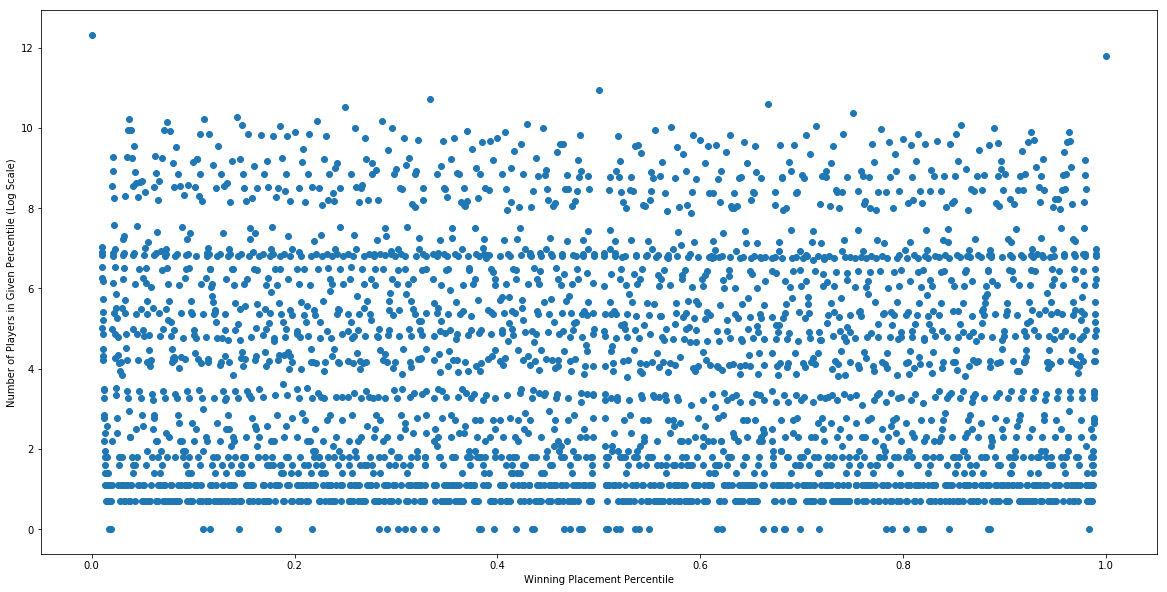

In [87]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(dict(train_df['winPlacePerc'].value_counts()).keys(), np.log(list(dict(train_df['winPlacePerc'].value_counts()).values())), 'o')
plt.xlabel("Winning Placement Percentile")
plt.ylabel("Number of Players in Given Percentile (Log Scale)")

Since the number of players for a given Winning Placement Percentile seems evenly spread, we don't need to do stratified sampling (Is this right? - Check with Shyam)

## Splitting the data into the independent and dependent sets, i.e. X_train and y_train

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(columns='winPlacePerc'), 
    train_df['winPlacePerc'], 
    test_size=0.2, 
    random_state=626
)

# Modelling the data with a Decision Tree

## Iterating through various tree depths to find the minimal mean squared error

We will iterate the tree through various depths, starting from 1 to 10, to find best decision tree depth with the least validation error. At each depth, we will conduct cross-validation on the training data and gather the average mean_squared_error score at that depth.

In [91]:
tree_depth_score_df = pd.DataFrame(columns=['depth', 'mean_mse'])

for i in range(1, 11):
    regr_dt = DecisionTreeRegressor(max_depth=i)
    score = np.mean(cross_val_score(regr_dt, X_train, y_train, cv=5, scoring='mean_squared_error'))
    tree_depth_score_df = tree_depth_score_df.append({
        'depth': i,
        'mean_mse': score
    }, ignore_index=True)
    
tree_depth_score_df

,depth,mean_mse
0,1.0,-0.036804
1,2.0,-0.024453
2,3.0,-0.019870
3,4.0,-0.017951
4,5.0,-0.016056
5,6.0,-0.014192
6,7.0,-0.013293
7,8.0,-0.012475
8,9.0,-0.011324
9,10.0,-0.010520


## Pick the optimal tree depth with the minimal mean squared error, train the relevant model

In [93]:
regr_dt = DecisionTreeRegressor(max_depth=10)
regr_dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [94]:
predicted = regr_dt.predict(X_test)

## Calculate the error differences between the model's predictions VS the actual

In [114]:
error_df = pd.DataFrame(columns=['model_predict_error'])
error_df['model_predict_error'] = predicted - y_test
error_df.head()

,model_predict_error
Id,
2803311,0.019005
1175201,0.044777
921767,0.058558
3526966,-0.005654
3778653,-0.022198


## Plot the prediction errors

Text(0,0.5,'Model Prediction Error')

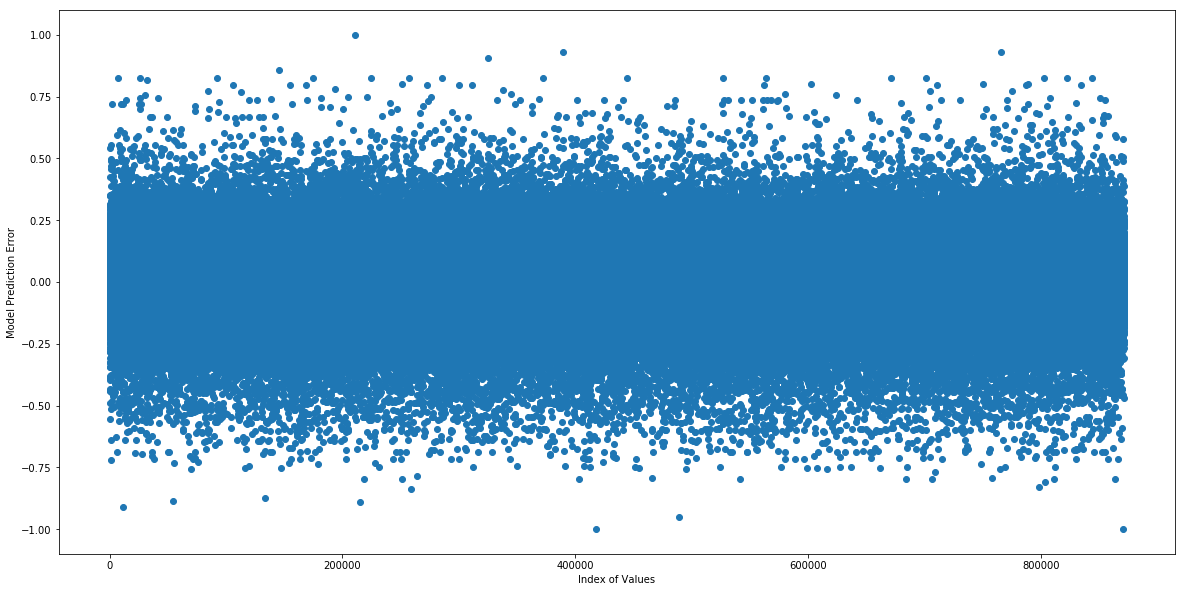

In [116]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot([i for i in range(0, len(predicted))], error_df['model_predict_error'], 'o')
plt.xlabel("Index of Values")
plt.ylabel("Model Prediction Error")

## Plot the count of prediction errors, in order to find the density of errors

Text(0,0.5,'Count of Errors')

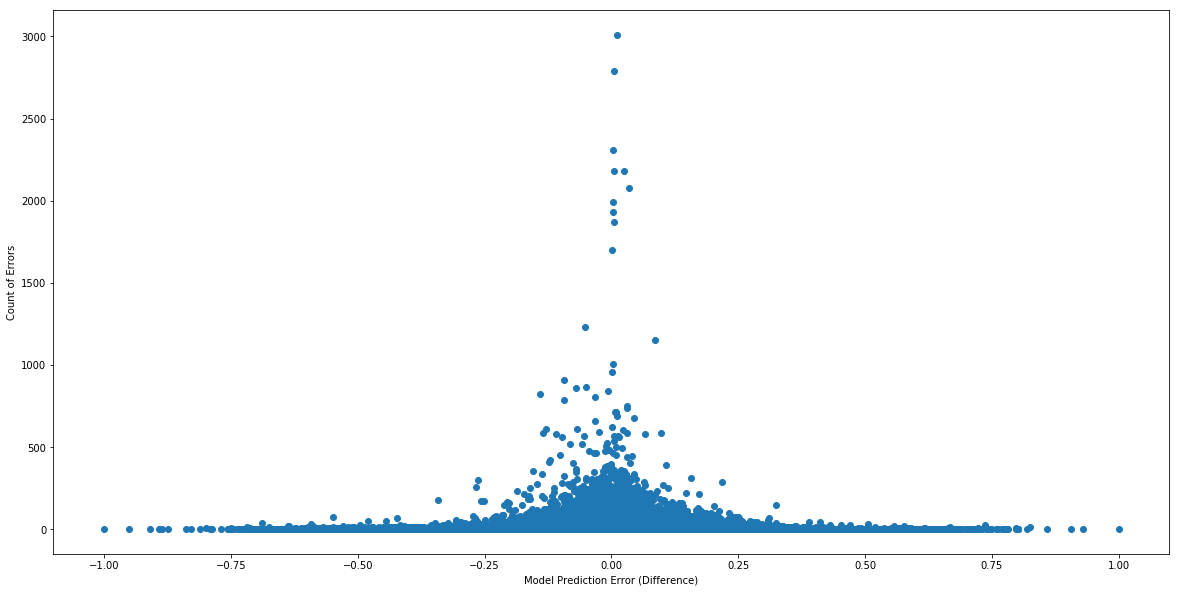

In [119]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(dict(error_df['model_predict_error'].value_counts()).keys(), list(dict(error_df['model_predict_error'].value_counts()).values()), 'o')
plt.xlabel("Model Prediction Error (Difference)")
plt.ylabel("Count of Errors")

Need to check with Shyam regarding how to determine what error range to use.

## Determine permutatation importance for the columns, with the Decision Tree model

1. For each column in X_train, shuffle the values within the column
2. Re-train the Decision Tree model with these shuffled values
3. Use this model to predict the outcomes
4. Get the error between the predicted value against the actual
5. Plot the error on the graph
6. Reset the values to that of their original positions and repeat step 1

The larger the errors from the shuffling of the given column's values, the more important it is as a feature to the model's predictions.